In [1]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shivamagarwal29/cow-lumpy-disease-dataset")

In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

dataset = ImageFolder(root=path, transform=train_transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [4]:
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet50(pretrained=True)

# Freeze backbone (important for small dataset)
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
model.fc = nn.Linear(model.fc.in_features, 2)

model = model.cuda()


c:\Users\PC0\Documents\bovine disease__pfe benzaouche_harbane\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC0\Documents\bovine disease__pfe benzaouche_harbane\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\PC0/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:24<00:00, 4.24MB/s]


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)                                                             
                                                         

In [6]:
import torch

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    return correct


In [10]:
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(num_epochs):
    
    # ===== TRAINING =====
    model.train()
    train_loss = 0
    train_correct = 0
    total_train = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += calculate_accuracy(outputs, labels)
        total_train += labels.size(0)
    
    train_accuracy = 100 * train_correct / total_train
    
    
    # ===== VALIDATION =====
    model.eval()
    val_loss = 0
    val_correct = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            val_correct += calculate_accuracy(outputs, labels)
            total_val += labels.size(0)
    
    val_accuracy = 100 * val_correct / total_val
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    print("-" * 40)


Epoch [1/30]
Train Accuracy: 85.96%
Validation Accuracy: 84.57%
----------------------------------------
Epoch [2/30]
Train Accuracy: 88.50%
Validation Accuracy: 84.04%
----------------------------------------
Epoch [3/30]
Train Accuracy: 86.76%
Validation Accuracy: 85.11%
----------------------------------------
Epoch [4/30]
Train Accuracy: 89.71%
Validation Accuracy: 81.91%
----------------------------------------
Epoch [5/30]
Train Accuracy: 89.04%
Validation Accuracy: 82.98%
----------------------------------------
Epoch [6/30]
Train Accuracy: 89.17%
Validation Accuracy: 80.32%
----------------------------------------
Epoch [7/30]
Train Accuracy: 89.57%
Validation Accuracy: 83.51%
----------------------------------------
Epoch [8/30]
Train Accuracy: 89.97%
Validation Accuracy: 81.38%
----------------------------------------
Epoch [9/30]
Train Accuracy: 90.78%
Validation Accuracy: 80.85%
----------------------------------------
Epoch [10/30]
Train Accuracy: 89.97%
Validation Accurac

In [11]:
torch.save(model.state_dict(), "best_model.pth")

In [12]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


In [13]:
cm = confusion_matrix(all_labels, all_preds)
print(cm)


[[75 23]
 [13 77]]


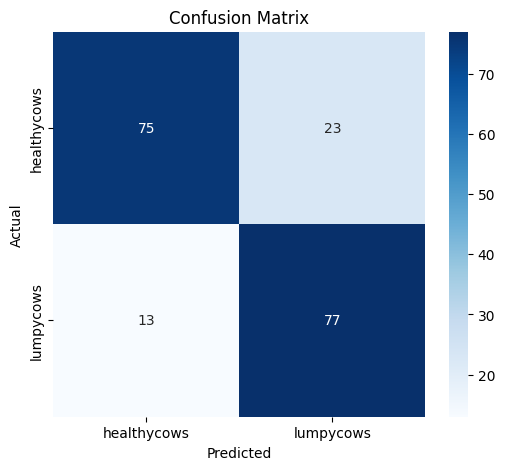

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

class_names = ["healthycows", "lumpycows"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### What Most Likely Happened in Your Case


Small dataset (936 images)

Using pretrained model

Probably resized to 224 or 256

The improvement likely came from:

✔ Better compatibility with pretrained weights
✔ Better feature extraction
✔ Cleaner batching
✔ Slight regularization effect